In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mp

import traceback

In [4]:
mp.rcParams['legend.fontsize'] = 45

pd.set_option('display.expand_frame_repr', False)
fn=0
path='./result/'

#Taking any image from the sample images
#In case of slanted image, straighten it using image-straighten.py, then use it
img = cv.imread('L2.png')
print(img.shape[1])
col=img[:,5:6]
print(col)
k = col.shape[0]
print(k)
print(col[k-1]==255)

1046
[[[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]

 [[0 0 0]]


In [5]:
# In[findFeaturPoints]
def findCapPoints(img):
    cpoints=[]
    dpoints=[]
    for i in range(img.shape[1]):
        col = img[:,i:i+1]
        k = col.shape[0]
        while k > 0:
            if col[k-1]==255:
                dpoints.append((i,k))
                break
            k-=1
        
        for j in range(col.shape[0]):
            if col[j]==255:
                cpoints.append((i,j))
                break
    return cpoints,dpoints

In [6]:
# In[wordSegment]
#*****************************************************************************#
def wordSegment(textLines):
    wordImgList=[]
    counter=0
    cl=0
    for txtLine in textLines:
        gray = cv.cvtColor(txtLine, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
        final_thr = cv.dilate(threshed,None,iterations = 1)

        plt.imshow(final_thr)
        plt.show()
        
        contours, hierarchy = cv.findContours(final_thr,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
        boundingBoxes = [cv.boundingRect(c) for c in contours]
        (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: b[1][0], reverse=False))
       
        for cnt in contours:
            area = cv.contourArea(cnt)
 
 #print area
            if area > 10000:
                print ('Area= ',area)
                x,y,w,h = cv.boundingRect(cnt)
                print (x,y,w,h)
                letterBgr = txtLine[0:txtLine.shape[1],x:x+w]
                wordImgList.append(letterBgr)
                go= cv.cvtColor(letterBgr, cv.COLOR_BGR2GRAY)
                th, letterBgr = cv.threshold(go, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
                letterBgr = fitToSize(letterBgr)
            
                cv.imwrite("result" + str(counter) +".jpg",letterBgr)
                counter=counter+1
        cl=cl+1
       
    return wordImgList

In [7]:
# In[fitToSize]
#*****************************************************************************#
def fitToSize(thresh1):
    
    mask = thresh1 > 0
    coords = np.argwhere(mask)

    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0)    # slices are exclusive at the top
    cropped = thresh1[x0:x1,y0:y1]
    return cropped
   
#*****************************************************************************#

In [8]:
# In[lineSegment]
#*****************************************************************************#
def lineSegment(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
   
    upper=[]
    lower=[]
    flag=True
    for i in range(threshed.shape[0]):

        col = threshed[i:i+1,:]
        cnt=0
        if flag:
            cnt=np.count_nonzero(col == 255)
            if cnt >0:
                upper.append(i)
                flag=False
        else:
            cnt=np.count_nonzero(col == 255)
            if cnt <1:
                lower.append(i)
                flag=True
    textLines=[]
    if len(upper)!= len(lower):lower.append(threshed.shape[0])
#    print upper
#    print lower
    for i in range(len(upper)):
        timg=img[upper[i]:lower[i],0:]
        
        if timg.shape[0]>5:
#            plt.imshow(timg)
#            plt.show()
            timg=cv.resize(timg,((timg.shape[1]*5,timg.shape[0]*8)))
            textLines.append(timg)

    return textLines
#*****************************************************************************#

In [9]:
# In[baselines]:
##******************************************************************************#
def baselines(letter2, cpoints, dpoints):
##-------------------------Creating upper baseline-------------------------------##
    colu = []
    for i in range(len(cpoints)):
        colu.append(cpoints[i][1])
    
    maxyu = max(colu)
    minyu = min(colu)
    avgu = (maxyu + minyu) // 2
    meanu = np.around(np.mean(colu)).astype(int)
    print('Upper:: Max, min, avg, mean:: ',maxyu, minyu, avgu, meanu)
    ##-------------------------------------------------------------------------------##
##-------------------------Creating lower baseline process 1--------------------------##
    cold = []
    for i in range(len(dpoints)):
        cold.append(dpoints[i][1])
    
    maxyd = max(cold)
    minyd = min(cold)
    avgd = (maxyd + minyd) // 2
    meand = np.around(np.mean(cold)).astype(int)
    print('Lower:: Max, min, avg, mean:: ',maxyd, minyd, avgd, meand)
##-------------------------Creating lower baseline process 2---------------------------##
    cn = []
    count = 0

    for i in range(h):
        for j in range(w):
            if(letterGray[i,j] == 255):
                count+=1
        if(count != 0):
            cn.append(count)
            count = 0    
    maxindex = cn.index(max(cn))
    print('Max pixels at: ',maxindex)
##------------------Printing upper and lower baselines-----------------------------##
    
    cv.line(letter2,(0,meanu),(w,meanu),(255,0,0),2)
    lb = 0
    if(maxindex > meand):
        lb = maxindex
        cv.line(letter2,(0,maxindex),(w,maxindex),(255,0,0),2)
    else:
        lb = meand
        cv.line(letter2,(0,meand),(w,meand),(255,0,0),2)
        
    plt.imshow(letter2)
    plt.show()
    return meanu, lb
##******************************************************************************###

In [10]:
# In[histogram]:
##*******************************************************************************###
def histogram(letter2, upper_baseline, lower_baseline):
    ##------------Making Histograms (Default)------------------------######
    cropped = letter2[upper_baseline:lower_baseline,0:w]
    plt.imshow(cropped)
    plt.show()
    colcnt = np.sum(cropped==255, axis=0)
    x = list(range(len(colcnt)))
    plt.plot(colcnt)
    plt.fill_between(x, colcnt, 1, facecolor='blue', alpha=0.5)
    plt.show()  
    return colcnt     
####---------------------------------------------------------------------------#####

In [11]:
# In[Visualize]:
##*******************************************************************************###
def visualize(letter2, upper_baseline, lower_baseline, min_pixel_threshold, min_separation_threshold, min_round_letter_threshold):
    seg = []
    seg1 = []
    seg2 = []
   ## Check if pixel count is less than min_pixel_threshold, add segmentation point
    for i in range(len(colcnt)):
        if(colcnt[i] < min_pixel_threshold):
            seg1.append(i)
          
    ## Check if 2 consequtive seg points are greater than min_separation_threshold in distance
    for i in range(len(seg1)-1):
        if(seg1[i+1]-seg1[i] > min_separation_threshold):
            seg2.append(seg1[i])
##------------Modified segmentation for removing circles----------------------------###            
    arr=[]
    for i in (seg2):
        arr1 = []
        j = upper_baseline
        while(j <= lower_baseline):
            if(letterGray[j,i] == 255):
                arr1.append(1)
            else:
                arr1.append(0)
            j+=1
        arr.append(arr1)
    print('At arr Seg here: ', seg2)
    
    ones = []
    for i in (arr):
        ones1 = []
        for j in range(len(i)):
            if (i[j] == 1):
                ones1.append([j])
        ones.append(ones1)
    
    diffarr = []
    for i in (ones):
        diff = i[len(i)-1][0] - i[0][0]
        diffarr.append(diff)
    print('Difference array: ',diffarr)
    
    for i in range(len(seg2)):
        if(diffarr[i] < min_round_letter_threshold):
            seg.append(seg2[i])
##---------------------------------------------------------------------------##
## Make the Cut 
    for i in range(len(seg)):
        letter3 = cv.line(letter2,(seg[i],0),(seg[i],h),(255,0,0),2)
    
    print("Does it work::::")
    plt.imshow(letter2)
    plt.show()
    return seg 


In [12]:
# In[segmentCharacters]
def segmentCharacters(seg,lettergray):
    s=0
    wordImgList = []
    global fn
    for i in range(len(seg)):
        if i==0:
            s=seg[i]
            if s > 15:
                wordImg = lettergray[0:,0:s]
                cntx=np.count_nonzero(wordImg == 255) 
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
            else:
                continue
        elif (i != (len(seg)-1)):
            if seg[i]-s > 15:
                wordImg = lettergray[0:,s:seg[i]]
                cntx=np.count_nonzero(wordImg == 255) 
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
                s=seg[i]
            else:
                continue
        else:
            wordImg = lettergray[0:,seg[len(seg)-1]:]
            cntx=np.count_nonzero(wordImg == 255) 
            print ('count',cntx)
            plt.imshow(wordImg)
            plt.show()
            fn=fn+1
        wordImgList.append(wordImg)

    return wordImgList


No. of Lines 1


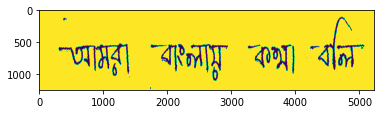

Area=  6478731.0
0 0 5230 1240
No. of Words 1
LetterGray shape:  (1240, 5230, 3)
Upper:: Max, min, avg, mean::  0 0 0 0
Lower:: Max, min, avg, mean::  1239 1239 1239 1239
Max pixels at:  0


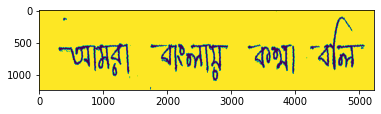

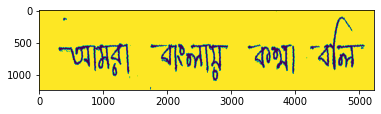

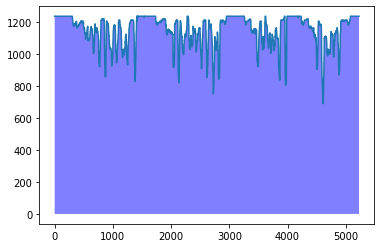

At arr Seg here:  []
Difference array:  []
Does it work::::


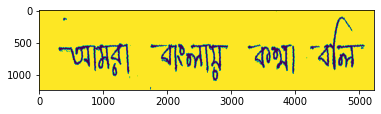

Original Image


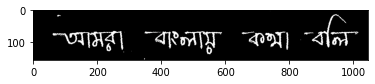

NoneType: None


In [13]:
# In[Main]:
try:
    textLines=lineSegment(img)
    print ('No. of Lines',len(textLines))
    imgList=wordSegment(textLines)
    print ('No. of Words',len(imgList))
    counter = 0
    for letterGray in imgList:
        print ('LetterGray shape: ',letterGray.shape)
        gray = cv.cvtColor(letterGray, cv.COLOR_BGR2GRAY)
        th, letterGray = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
        letterGray = fitToSize(letterGray)
        letter2 = letterGray.copy()
        letterGray = cv.dilate(letterGray,None,iterations = 4)

        h = letterGray.shape[0]
        w = letterGray.shape[1]
        
        cpoints, dpoints=findCapPoints(letterGray)        
        meanu, lb = baselines(letter2, cpoints, dpoints)
        
##-----------Final Baseline row numbers-----------------------####
#       Ignore all points avove and below these rows 
        upper_baseline = meanu
        lower_baseline = lb
        
##--------------------Make histogram-------------------------------------###   
        
        colcnt = histogram(letter2, upper_baseline, lower_baseline)
        
###------------------------Visualize segmentation------------------------------#####        
        ## Tuning Parameters
        min_pixel_threshold = 5
        min_separation_threshold = 10
        min_round_letter_threshold = 190
        
        seg = visualize(letter2, upper_baseline, lower_baseline, min_pixel_threshold, min_separation_threshold, min_round_letter_threshold)
        wordImgList = segmentCharacters(seg,letterGray)
        for i in wordImgList:
            cv.imwrite("./result" + str(counter) +".jpeg",i)
            counter=counter+1
        
###---------------------------------------------------------------------------#####        
        
    print('Original Image')         
    plt.imshow(img)
    plt.show()

except Exception as e:
    print ('Error Message ',e)
    cv.destroyAllWindows()
    traceback.print_exc()
    pass

traceback.print_exc() 